# Picking the gamma value for a SVM with a Radial Basis Function kernel

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import train_test_split

%matplotlib inline

When we train a support vector machine (SVM) with a radial basis function (rbf) kernel, we pick two main parameters.
The ``C`` parameter, common to all kernels, determines how much we maximise the SVM's margin vs correctly classifying more of the training data. This is a regularising parameter.

The ``gamma`` parameter appears as follows.
Using a rbf kernel, we measure similarity between datapoints by $k(x, y) = \exp(-\gamma||x-y||^2)$.
If $\gamma||x-y||^2$ is very small -- i.e., if $\frac{1}{\gamma}$ is much larger than $||x-y||^2$ -- $k(x, y)$ will be close to 1.
So a small $\gamma$ value, relative to the distances between datapoints, means the influence of a single datapoint reaches over most of the dataset.
If $\gamma||x-y||^2$ is very large, then $k(x, y)$ will be close to 0.
That is, for a large $\gamma$ value, a given datapoint has influence only on datapoints very close to it.

See <https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html> for an exploration of how these parameters influence the decision boundary. We use code from <https://scikit-learn.org/stable/auto_examples/svm/plot_iris.html> for plotting.

First, we load the dataset. We will use the first two dimensions of the iris dataset.

In [2]:
iris = datasets.load_iris()

In [3]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

In [4]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_data(ax, X0, X1, y, xx, yy, title):
    """Plot the data
    
    Parameters
    ----------
    ax: matplotlib axes object
    X0: first (horizontal) dimension
    X1: second (vertical) dimension
    y: label
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    title: text to display above figure

    """
    ax.scatter(X0, X1, c=y, cmap=plt.cm.bwr, s=50, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('first feature')
    ax.set_ylabel('second feature')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)


## Picking a good gamma value

To pick a good ``gamma`` value, we would use cross validation. To do cross validation, we need to know what range sensible ``gamma`` values lie in.
To find this range, we use a heuristic.
We want the influence of each datapoint to extend over some but not all of the dataset -- that is, we want ``gamma`` to be some value such that $\gamma||x-y||^2$ is neither very large nor very small.

We thus want $\frac{1}{\gamma}$ to be of similar magnitude to "typical" values of $||x-y||^2$.

In [5]:
pairs = itertools.combinations(X, r=2)
distances = [np.linalg.norm(a-b)**2 for a,b in pairs]
distances.sort()
gamma_values = [distances[int(len(distances)*frac)] for frac in [0.1, 0.3, 0.5, 0.7, 0.9]]
print(gamma_values)

[0.12999999999999998, 0.5300000000000004, 1.2099999999999993, 2.119999999999998, 4.039999999999999]


We see that the distances between points in the dataset are largely between 0.13 and 4.04.
We plot the SVM decision boundaries with these ``gamma`` values.

We also plot the SVM decision boundaries with ``gamma`` values of 0.001, 0.01, 40 and 400, to show values outside this range.
We split the dataset to use a third for validation.
Looking at the scores on the validation set, we get a better model for ``gamma`` values in the range between 0.13 and 4.04

In [6]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

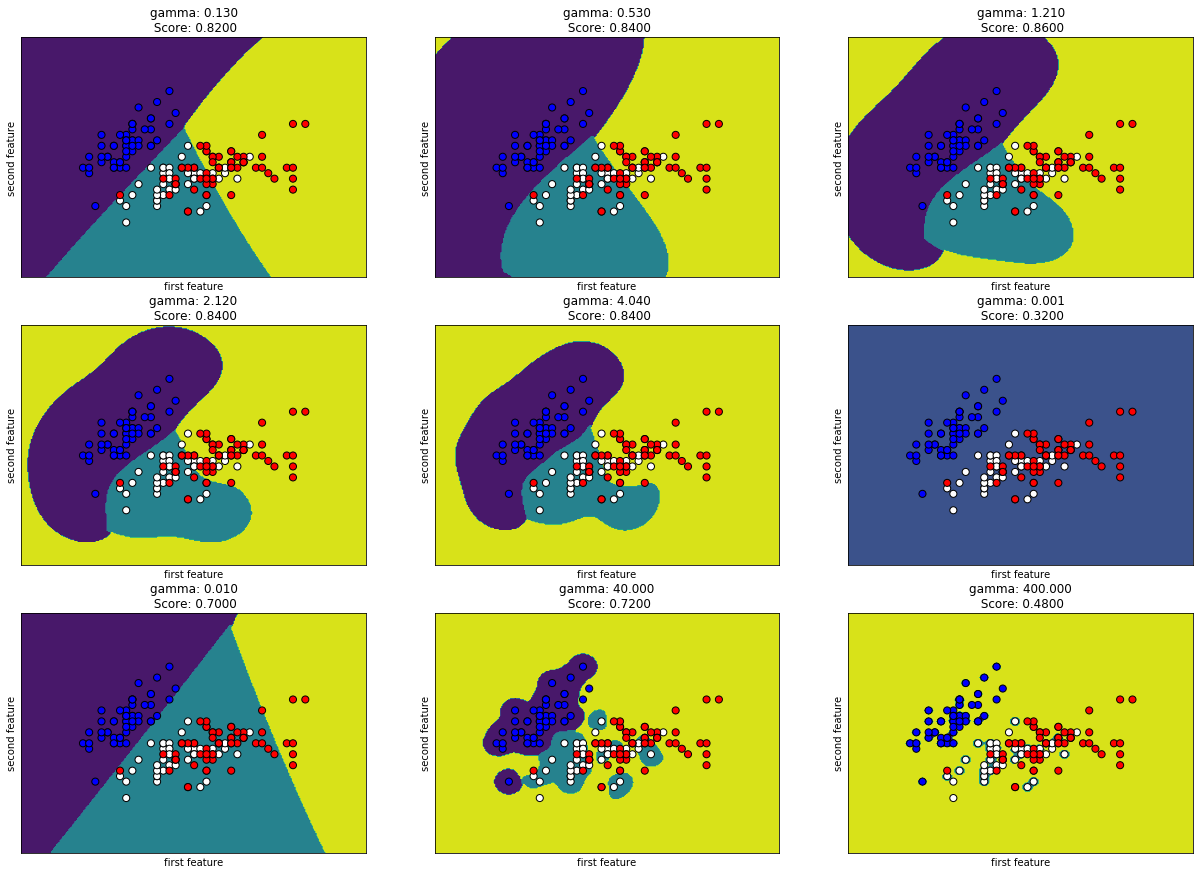

In [7]:
gamma_values.extend([0.001, 0.01, 40, 400])
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter

fig, sub = plt.subplots(3, 3, figsize=(21, 15))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for gamma, ax in zip(gamma_values, sub.flatten()[:len(gamma_values)]):
    clf = svm.SVC(kernel='rbf', gamma=gamma, C=C)
    clf.fit(X_train, y_train)
    plot_contours(ax, clf, xx, yy)
    plot_data(ax, X0, X1, y, xx, yy, 'gamma: %.3f\n Score: %.4f' % (gamma, clf.score(X_test, y_test)))